uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 32
captchaWidth = 100
captchaMarginX = 4
captchaMarginY = 4
batch_size = 10

char_dict = string.digits
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 400 if not smoke_test else 10
TrainingSample = 2000 if not smoke_test else 100 # number of captchas generated for training 
hidden_state_dim = 32

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 676
text 46 captcha shape (32, 100) noise 0.4544260367893595
text 86 captcha shape (32, 100) noise 0.7349130718510787
text 57 captcha shape (32, 100) noise 0.45085893862321386
text 64 captcha shape (32, 100) noise 0.14487270498010985
text 73 captcha shape (32, 100) noise 0.5237591190172621
text 18 captcha shape (32, 100) noise 0.34722931270777685
text 86 captcha shape (32, 100) noise 0.2545951845706337
text 35 captcha shape (32, 100) noise 0.41826164900793994
text 96 captcha shape (32, 100) noise 0.888199115681341
text 54 captcha shape (32, 100) noise 0.24033332016780476
text 94 captcha shape (32, 100) noise 0.0765481091230279
number of samples in group 642
text 718 captcha shape (32, 100) noise 0.8717861740935142
text 324 captcha shape (32, 100) noise 0.1825738804960814
text 347 captcha shape (32, 100) noise 0.15320980540968557
text 961 captcha shape (32, 100) noise 0.8247861750353204
text 920 captcha shape (32, 100) noise 

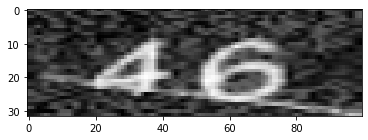

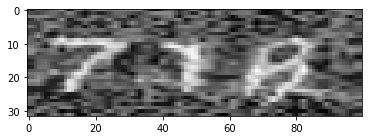

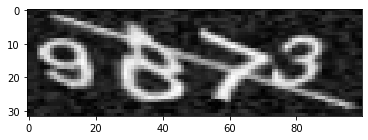

In [3]:
for lst in captcha_generated:
    if len(lst) > 0:
        plt.imshow(lst[0][1], cmap="Greys")
        plt.show()

In [4]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    #noise = noise.data.item()
    #print(chars, noise)
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    
    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [5]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [6]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [7]:
class NoiseNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseNet, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.fc20 = nn.Linear(1024, img_size[0] * img_size[1])
        self.fc21 = nn.Linear(img_size[0] * img_size[1], out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1])
        hidden = F.relu(self.fc0(img))
        hidden = self.fc1(hidden)
        # mean of noise, used in normal distribution
        noise_map = self.fc20(F.relu(self.fc2(F.relu(hidden))))
        mean =  self.fc21(F.relu(noise_map))
        # std used in normal distribution
        sigma = torch.tensor([[1e-8] for _ in range(BS)]).float()
        if USE_CUDA:
            sigma = sigma.cuda()
        return mean, sigma, noise_map

In [8]:
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [9]:
class InputEmbedding(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(InputEmbedding, self).__init__()
        self.img_size = img_size
        
        # observe layers
        self.nnfc = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.convBN1 = nn.BatchNorm2d(64)
        self.convBN2 = nn.BatchNorm2d(64)
        self.convBN3 = nn.BatchNorm2d(64)

    def forward(self, img, noise_map):
        
        BATCH_SIZE = img.shape[0]
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        img = self.pool(F.relu(self.convBN3(self.conv3(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 1280))
        return img

In [10]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        
        # branches
        self.pfc1 = nn.Linear(1280 + hidden_state_dim + 1, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.pfc3 = nn.Linear(1024, 1024)
        self.pfc4 = nn.Linear(1024, output_size)

    def forward(self, img_embedded, hid, noise_batch):
        
        BATCH_SIZE = img_embedded.shape[0]

        img = torch.cat((img_embedded, hid, noise_batch), 1)
        
        out = F.relu(self.pfc1(img))
        out = F.relu(self.pfc2(out))
        out = F.relu(self.pfc3(out))
        out = self.pfc4(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [11]:
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 1)
        #print(input_x, input_x.shape)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

In [12]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [13]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []

def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, train_accuracies, train_char_accuracies, train_noise_differences, test_noise_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + captchaModel.num_char_domain[0]
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()[0]
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [14]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [15]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_char_accuracies
    }
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

Optimizing...


C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss at epoch 1 is 1089193358254931.1; Epoch takes 108 seconds
loss at epoch 2 is 380106962046549.94; Epoch takes 107 seconds
loss at epoch 3 is 240933917721362.34; Epoch takes 113 seconds
loss at epoch 4 is 188114521555468.16; Epoch takes 111 seconds
loss at epoch 5 is 164160449601863.78; Epoch takes 106 seconds
use_train = True AVG Noise Difference: 0.07963012678774799 Total correct: 36 accuracy:36/2000= 0.018 char_accuracy:1191/6006= 0.1983016983016983
use_train = False AVG Noise Difference: 0.07870691949961227 Total correct: 16 accuracy:16/1000= 0.016 char_accuracy:597/3017= 0.19787868743785217
N_predicted: 2 | Actual N: 4 | Predicted Noise: 0.421 | Actual Noise: 0.367 | Predicted Text: 57 | Actual Text: 0777 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.873 | Actual Noise: 0.915 | Predicted Text: 765 | Actual Text: 196 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.275 | Actual Noise: 0.027 | Predicted Text: 52 | Actual Text: 27 | Correct: 0
N_pred

loss at epoch 22 is 49815752086585.35; Epoch takes 106 seconds
loss at epoch 23 is 46447356914040.86; Epoch takes 106 seconds
loss at epoch 24 is 47986615080189.984; Epoch takes 106 seconds
loss at epoch 25 is 40441943158161.41; Epoch takes 106 seconds
use_train = True AVG Noise Difference: 0.03779446256013536 Total correct: 310 accuracy:310/2000= 0.155 char_accuracy:3176/6006= 0.5288045288045288
use_train = False AVG Noise Difference: 0.03618919046376447 Total correct: 136 accuracy:136/1000= 0.136 char_accuracy:1582/3017= 0.5243619489559165
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.254 | Actual Noise: 0.24 | Predicted Text: 7370 | Actual Text: 9303 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.789 | Actual Noise: 0.783 | Predicted Text: 6534 | Actual Text: 4634 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.195 | Actual Noise: 0.113 | Predicted Text: 562 | Actual Text: 562 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.869 | Act

loss at epoch 42 is 36110345236643.83; Epoch takes 106 seconds
loss at epoch 43 is 34971376143695.89; Epoch takes 106 seconds
loss at epoch 44 is 36992066554822.664; Epoch takes 106 seconds
loss at epoch 45 is 31747342332854.277; Epoch takes 106 seconds
use_train = True AVG Noise Difference: 0.03774020236924238 Total correct: 736 accuracy:736/2000= 0.368 char_accuracy:4288/6006= 0.713952713952714
use_train = False AVG Noise Difference: 0.03594134312432762 Total correct: 362 accuracy:362/1000= 0.362 char_accuracy:2164/3020= 0.7165562913907285
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.848 | Actual Noise: 0.891 | Predicted Text: 511 | Actual Text: 311 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.242 | Actual Noise: 0.177 | Predicted Text: 6988 | Actual Text: 5988 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.559 | Actual Noise: 0.545 | Predicted Text: 82 | Actual Text: 82 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.226 | Actual

loss at epoch 63 is 31698098737381.36; Epoch takes 106 seconds
loss at epoch 64 is 32927798229729.27; Epoch takes 106 seconds
loss at epoch 65 is 36243794412306.414; Epoch takes 106 seconds
use_train = True AVG Noise Difference: 0.03558973215552692 Total correct: 1057 accuracy:1057/2000= 0.5285 char_accuracy:4848/6006= 0.8071928071928072
use_train = False AVG Noise Difference: 0.03408508468227798 Total correct: 523 accuracy:523/1000= 0.523 char_accuracy:2384/2987= 0.7981252092400402
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.778 | Actual Noise: 0.794 | Predicted Text: 50 | Actual Text: 40 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.88 | Actual Noise: 0.962 | Predicted Text: 299 | Actual Text: 299 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.224 | Actual Noise: 0.182 | Predicted Text: 110 | Actual Text: 110 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.882 | Actual Noise: 0.956 | Predicted Text: 354 | Actual Text: 394 | Correc

loss at epoch 84 is 26644687104114.695; Epoch takes 106 seconds
loss at epoch 85 is 27996927705808.895; Epoch takes 106 seconds
use_train = True AVG Noise Difference: 0.03611113799751518 Total correct: 1386 accuracy:1386/2000= 0.693 char_accuracy:5300/6006= 0.8824508824508824
use_train = False AVG Noise Difference: 0.032959478053873004 Total correct: 690 accuracy:690/1000= 0.69 char_accuracy:2632/2984= 0.8820375335120644
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.9 | Actual Noise: 0.939 | Predicted Text: 4203 | Actual Text: 4204 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.301 | Actual Noise: 0.267 | Predicted Text: 93 | Actual Text: 93 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.205 | Actual Noise: 0.132 | Predicted Text: 29 | Actual Text: 29 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.653 | Actual Noise: 0.64 | Predicted Text: 432 | Actual Text: 432 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.681 | Actu

loss at epoch 104 is 28403543097868.293; Epoch takes 106 seconds
loss at epoch 105 is 26014270042144.77; Epoch takes 106 seconds
use_train = True AVG Noise Difference: 0.03436573092344035 Total correct: 1525 accuracy:1525/2000= 0.7625 char_accuracy:5488/6006= 0.9137529137529138
use_train = False AVG Noise Difference: 0.03154641196909667 Total correct: 764 accuracy:764/1000= 0.764 char_accuracy:2733/2990= 0.914046822742475
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.412 | Actual Noise: 0.407 | Predicted Text: 5328 | Actual Text: 5328 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.482 | Actual Noise: 0.484 | Predicted Text: 20 | Actual Text: 20 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.901 | Actual Noise: 0.984 | Predicted Text: 95 | Actual Text: 93 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.324 | Actual Noise: 0.313 | Predicted Text: 32 | Actual Text: 32 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.3 | Actu

loss at epoch 125 is 24709100321243.137; Epoch takes 106 seconds
use_train = True AVG Noise Difference: 0.03379334884381931 Total correct: 1618 accuracy:1618/2000= 0.809 char_accuracy:5589/6006= 0.9305694305694305
use_train = False AVG Noise Difference: 0.03109789035488368 Total correct: 790 accuracy:790/1000= 0.79 char_accuracy:2739/2971= 0.9219118142039717
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.201 | Actual Noise: 0.116 | Predicted Text: 583 | Actual Text: 583 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.353 | Actual Noise: 0.348 | Predicted Text: 83 | Actual Text: 83 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.763 | Actual Noise: 0.752 | Predicted Text: 2996 | Actual Text: 2996 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.65 | Actual Noise: 0.661 | Predicted Text: 198 | Actual Text: 198 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.67 | Actual Noise: 0.662 | Predicted Text: 621 | Actual Text: 621 | Co

loss at epoch 145 is 24399798485254.16; Epoch takes 106 seconds
use_train = True AVG Noise Difference: 0.03565457231504781 Total correct: 1629 accuracy:1629/2000= 0.8145 char_accuracy:5607/6006= 0.9335664335664335
use_train = False AVG Noise Difference: 0.03389374237281292 Total correct: 818 accuracy:818/1000= 0.818 char_accuracy:2843/3032= 0.9376649076517151
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.202 | Actual Noise: 0.116 | Predicted Text: 168 | Actual Text: 168 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.232 | Actual Noise: 0.186 | Predicted Text: 707 | Actual Text: 707 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.866 | Actual Noise: 0.86 | Predicted Text: 29 | Actual Text: 29 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.87 | Actual Noise: 0.904 | Predicted Text: 9284 | Actual Text: 9284 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.175 | Actual Noise: 0.019 | Predicted Text: 8536 | Actual Text: 8536 |

loss at epoch 165 is 23802257260806.145; Epoch takes 111 seconds
use_train = True AVG Noise Difference: 0.032572347200390345 Total correct: 1696 accuracy:1696/2000= 0.848 char_accuracy:5679/6006= 0.9455544455544456
use_train = False AVG Noise Difference: 0.030004529431613986 Total correct: 861 accuracy:861/1000= 0.861 char_accuracy:2870/3023= 0.9493880251405888
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.191 | Actual Noise: 0.076 | Predicted Text: 2724 | Actual Text: 2724 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.297 | Actual Noise: 0.273 | Predicted Text: 67 | Actual Text: 67 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.494 | Actual Noise: 0.491 | Predicted Text: 4896 | Actual Text: 4896 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.277 | Actual Noise: 0.29 | Predicted Text: 9003 | Actual Text: 9003 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.256 | Actual Noise: 0.228 | Predicted Text: 82 | Actual Text: 8

loss at epoch 185 is 23334301520494.586; Epoch takes 149 seconds
use_train = True AVG Noise Difference: 0.033865328738440066 Total correct: 1743 accuracy:1743/2000= 0.8715 char_accuracy:5729/6006= 0.9538794538794538
use_train = False AVG Noise Difference: 0.0327288643964639 Total correct: 880 accuracy:880/1000= 0.88 char_accuracy:2881/3012= 0.9565073041168659
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.741 | Actual Noise: 0.749 | Predicted Text: 58 | Actual Text: 58 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.905 | Actual Noise: 0.974 | Predicted Text: 13 | Actual Text: 13 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.701 | Actual Noise: 0.675 | Predicted Text: 8261 | Actual Text: 8261 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.675 | Actual Noise: 0.684 | Predicted Text: 943 | Actual Text: 943 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.858 | Actual Noise: 0.864 | Predicted Text: 371 | Actual Text: 371 | C

loss at epoch 205 is 22222273099071.492; Epoch takes 158 seconds
use_train = True AVG Noise Difference: 0.030082703764379475 Total correct: 1756 accuracy:1756/2000= 0.878 char_accuracy:5748/6006= 0.957042957042957
use_train = False AVG Noise Difference: 0.02861031090565431 Total correct: 864 accuracy:864/1000= 0.864 char_accuracy:2870/3017= 0.951276102088167
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.606 | Actual Noise: 0.588 | Predicted Text: 767 | Actual Text: 767 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.386 | Actual Noise: 0.389 | Predicted Text: 56 | Actual Text: 56 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.651 | Actual Noise: 0.65 | Predicted Text: 43 | Actual Text: 43 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.859 | Actual Noise: 0.862 | Predicted Text: 5698 | Actual Text: 8898 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.356 | Actual Noise: 0.358 | Predicted Text: 6531 | Actual Text: 6531 | C

use_train = True AVG Noise Difference: 0.02986774499313707 Total correct: 1740 accuracy:1740/2000= 0.87 char_accuracy:5734/6006= 0.9547119547119547
use_train = False AVG Noise Difference: 0.028897088003702318 Total correct: 891 accuracy:891/1000= 0.891 char_accuracy:2860/2972= 0.9623149394347241
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.347 | Actual Noise: 0.348 | Predicted Text: 27 | Actual Text: 27 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.571 | Actual Noise: 0.552 | Predicted Text: 97 | Actual Text: 57 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.912 | Actual Noise: 0.971 | Predicted Text: 760 | Actual Text: 760 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.216 | Actual Noise: 0.198 | Predicted Text: 8023 | Actual Text: 8023 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.666 | Actual Noise: 0.666 | Predicted Text: 0277 | Actual Text: 0277 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.421

use_train = True AVG Noise Difference: 0.030248568880189137 Total correct: 1797 accuracy:1797/2000= 0.8985 char_accuracy:5790/6006= 0.964035964035964
use_train = False AVG Noise Difference: 0.028705937751892542 Total correct: 898 accuracy:898/1000= 0.898 char_accuracy:2930/3037= 0.9647678630227198
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.16 | Actual Noise: 0.015 | Predicted Text: 36 | Actual Text: 36 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.7 | Actual Noise: 0.701 | Predicted Text: 8472 | Actual Text: 8472 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.844 | Actual Noise: 0.878 | Predicted Text: 65 | Actual Text: 65 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.717 | Actual Noise: 0.763 | Predicted Text: 5018 | Actual Text: 5018 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.796 | Actual Noise: 0.807 | Predicted Text: 71 | Actual Text: 71 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.722 | 

use_train = False AVG Noise Difference: 0.02940461414119506 Total correct: 914 accuracy:914/1000= 0.914 char_accuracy:2931/3022= 0.9698874917273329
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.698 | Actual Noise: 0.694 | Predicted Text: 698 | Actual Text: 698 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.446 | Actual Noise: 0.447 | Predicted Text: 58 | Actual Text: 58 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.308 | Actual Noise: 0.315 | Predicted Text: 92 | Actual Text: 92 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.61 | Actual Noise: 0.636 | Predicted Text: 90 | Actual Text: 90 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.209 | Actual Noise: 0.162 | Predicted Text: 353 | Actual Text: 353 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.767 | Actual Noise: 0.784 | Predicted Text: 193 | Actual Text: 103 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.419 | Actual Noise: 0.429 | P

N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.909 | Actual Noise: 0.951 | Predicted Text: 8224 | Actual Text: 8224 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.28 | Actual Noise: 0.27 | Predicted Text: 63 | Actual Text: 63 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.729 | Actual Noise: 0.724 | Predicted Text: 4031 | Actual Text: 4031 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.207 | Actual Noise: 0.176 | Predicted Text: 257 | Actual Text: 257 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.164 | Actual Noise: 0.039 | Predicted Text: 67 | Actual Text: 67 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.75 | Actual Noise: 0.751 | Predicted Text: 520 | Actual Text: 520 | Correct: 3
use_train = False AVG Noise Difference: 0.05165545758364067 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:32/32= 1.0
loss at epoch 286 is 22313806594703.36; Epoch takes 162 seconds
loss at epoch 287 is 21073855756763.

N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.913 | Actual Noise: 0.976 | Predicted Text: 515 | Actual Text: 515 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.265 | Actual Noise: 0.241 | Predicted Text: 70 | Actual Text: 70 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.692 | Actual Noise: 0.672 | Predicted Text: 8359 | Actual Text: 8359 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.531 | Actual Noise: 0.524 | Predicted Text: 7915 | Actual Text: 7915 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.842 | Actual Noise: 0.84 | Predicted Text: 3481 | Actual Text: 3481 | Correct: 4
use_train = False AVG Noise Difference: 0.028380421277978806 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:32/32= 1.0
loss at epoch 306 is 20856278776414.207; Epoch takes 140 seconds
loss at epoch 307 is 20375575777902.59; Epoch takes 138 seconds
loss at epoch 308 is 20208089843302.4; Epoch takes 133 seconds
loss at epoch 309 is 2171859544

use_train = False AVG Noise Difference: 0.016524658475687282 Total correct: 10 accuracy:10/10= 1.0 char_accuracy:31/31= 1.0
loss at epoch 326 is 20552838223298.57; Epoch takes 143 seconds
loss at epoch 327 is 20390192119939.066; Epoch takes 134 seconds
loss at epoch 328 is 21094094387478.52; Epoch takes 133 seconds
loss at epoch 329 is 20243641795346.434; Epoch takes 135 seconds
loss at epoch 330 is 20073429285797.883; Epoch takes 135 seconds
use_train = True AVG Noise Difference: 0.02687225895904818 Total correct: 1854 accuracy:1854/2000= 0.927 char_accuracy:5855/6006= 0.9748584748584749
use_train = False AVG Noise Difference: 0.02642590011018778 Total correct: 913 accuracy:913/1000= 0.913 char_accuracy:2938/3025= 0.9712396694214877
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.672 | Actual Noise: 0.668 | Predicted Text: 230 | Actual Text: 230 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.813 | Actual Noise: 0.824 | Predicted Text: 595 | Actual Text: 595 | Correct

loss at epoch 346 is 21095983482011.65; Epoch takes 136 seconds
loss at epoch 347 is 20902034918866.94; Epoch takes 134 seconds
loss at epoch 348 is 20880643594715.137; Epoch takes 134 seconds
loss at epoch 349 is 20601189008146.426; Epoch takes 134 seconds
loss at epoch 350 is 20253569696006.137; Epoch takes 138 seconds
use_train = True AVG Noise Difference: 0.029032760714275428 Total correct: 1834 accuracy:1834/2000= 0.917 char_accuracy:5831/6006= 0.9708624708624709
use_train = False AVG Noise Difference: 0.02893361127489345 Total correct: 926 accuracy:926/1000= 0.926 char_accuracy:2965/3040= 0.975328947368421
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.206 | Actual Noise: 0.162 | Predicted Text: 969 | Actual Text: 969 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.472 | Actual Noise: 0.465 | Predicted Text: 3065 | Actual Text: 3065 | Correct: 4
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.388 | Actual Noise: 0.392 | Predicted Text: 03 | Actual Text: 03 | C

loss at epoch 367 is 19829435985952.766; Epoch takes 135 seconds
loss at epoch 368 is 20753380422189.055; Epoch takes 134 seconds
loss at epoch 369 is 21062285754367.992; Epoch takes 135 seconds
loss at epoch 370 is 20604434974375.934; Epoch takes 143 seconds
use_train = True AVG Noise Difference: 0.02802884639657119 Total correct: 1864 accuracy:1864/2000= 0.932 char_accuracy:5865/6006= 0.9765234765234765
use_train = False AVG Noise Difference: 0.027795664810990026 Total correct: 945 accuracy:945/1000= 0.945 char_accuracy:2939/2997= 0.9806473139806473
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.297 | Actual Noise: 0.279 | Predicted Text: 249 | Actual Text: 249 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.43 | Actual Noise: 0.44 | Predicted Text: 975 | Actual Text: 975 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.292 | Actual Noise: 0.284 | Predicted Text: 45 | Actual Text: 45 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.298 | 

loss at epoch 387 is 20054801364090.87; Epoch takes 133 seconds
loss at epoch 388 is 20862275217457.14; Epoch takes 134 seconds
loss at epoch 389 is 22125045887139.832; Epoch takes 136 seconds
loss at epoch 390 is 20676180808564.72; Epoch takes 143 seconds
use_train = True AVG Noise Difference: 0.026687396027161147 Total correct: 1853 accuracy:1853/2000= 0.9265 char_accuracy:5851/6006= 0.9741924741924742
use_train = False AVG Noise Difference: 0.025269612656697606 Total correct: 923 accuracy:923/1000= 0.923 char_accuracy:2913/2992= 0.973596256684492
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.386 | Actual Noise: 0.393 | Predicted Text: 527 | Actual Text: 527 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.497 | Actual Noise: 0.513 | Predicted Text: 78 | Actual Text: 78 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.189 | Actual Noise: 0.151 | Predicted Text: 93 | Actual Text: 93 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.603 | Ac

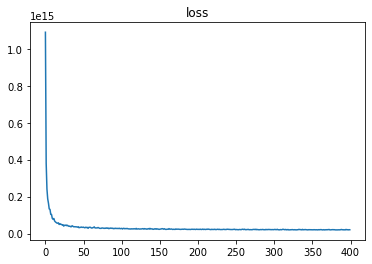

In [16]:
def mask_operation(i, n):
    return i < (n + MIN_N)
    
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()

        self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        self.noiseNet = NoiseNet((captchaHeight, captchaWidth), 1)
        self.char_dict = char_dict # letter dictionary
        self.charNet = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain)) # with noise
        self.inputEmbedding = InputEmbedding((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain))
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        self.hid_net = simpleNN(hidden_state_dim + len(char_dict) + MAX_N + 1, hidden=128, out_size = hidden_state_dim, t = "mlp")
        self.h0 = nn.Parameter(torch.zeros(hidden_state_dim))
        self.noise_dim = 128
        self.charRNN = nn.RNN(1280 + self.noise_dim + MAX_N, 256, 2, nonlinearity='relu', dropout=0.1, batch_first=False)
        self.charLinearMap = nn.Linear(256, len(char_dict))
        self.h_0 = nn.Parameter(torch.zeros(2, 1, 256))
            
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input
                
    def guide_rnn(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        
        img = observations["captcha"].float()
        BS = img.shape[0]
        # flatten representation of img
        img_raw = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
                
        with pyro.plate("data", img.shape[0]):
            
            prob = self.numNet(img)
            #prob = torch.mean(prob, dim=0)
            N_index = pyro.sample("num_char", dist.Categorical(prob).to_event(0))
            N_index = torch.add(N_index, self.num_char_domain[0])
            
            # posterior to the noise
            noise_mean, noise_sig, noise_map = self.noiseNet(img)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, None)
            
            noise_batch = noise_batch.repeat(1, self.noise_dim)
            i = torch.arange(0, int(MAX_N))
            if USE_CUDA:
                i = i.cuda()
            i_onehot = F.one_hot(i, num_classes=MAX_N).float() # one hot format of N and index of letter
            i_onehot = torch.reshape(i_onehot, (MAX_N, 1, MAX_N)).repeat(1, BS, 1)
            input_emb = input_emb.unsqueeze(0).repeat(MAX_N, 1, 1)
            noise_batch = noise_batch.unsqueeze(0).repeat(MAX_N, 1, 1)
            rnn_input = torch.cat((input_emb, noise_batch, i_onehot), dim=2)
            h_0_contig = self.h_0.expand(2, BS, 256).contiguous()
            outputs, hn = self.charRNN(rnn_input, h_0_contig)
        
            for i in range(MAX_N):
                sample_mask = i < N_index
                char_i = F.log_softmax(self.charLinearMap(outputs[i]), dim=1)
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(char_i).mask(sample_mask).to_event(0))
    
    def model_rec(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            
            num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain)).unsqueeze(0).repeat(BS, 1)
        
            if self.use_cuda:
                num_p = num_p.cuda()

            # sample the number of characters
            N_index = pyro.sample("num_char", dist.Categorical(num_p).to_event(0))
            
            N_index = torch.add(N_index,  self.num_char_domain[0])
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            
            def _rec(i):
                if i < MAX_N:
                    sample_mask = i < N_index
                    num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                    if self.use_cuda:
                        num_c_i = num_c_i.cuda()
                    c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).mask(sample_mask).to_event(0))
                    sampled_c.append((sample_mask, c_i))
                    _rec(i + 1)
            _rec(0)
                
            # sample characters
            rendered_images = []
            
            # does not contain any sample statements
            def _render_imgs(i):
                
                def _get_chars(j, chars, i):
                    if j < MAX_N:
                        if sampled_c[j][0][i]:
                            chars += self.char_dict[sampled_c[j][1][i]]
                            return _get_chars(j + 1, chars, i)
                    return chars
                if i < BS:
                    chars = ""
                    chars = _get_chars(0, "", i)
                    #print("chars", chars)
                    rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                    rendered_images.append(rendered_image)
                    _render_imgs(i + 1)
                    
            _render_imgs(0)
                               
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model_rec, captchaModel.guide_rnn, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_metrics_noise_in_charnet_rnn_400_noise_128.json")


Logs